<a href="https://colab.research.google.com/github/petr-ngn/CNN_Real_Estate_Offices_Properties_Listing/blob/main/CNN_Real_Estate_Offices_Properties_Listing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-label Classificiation of real-estate offices' properties using Convolutional Neural Networks (CNN)**



```
# This is formatted as code
```

*Author:* **Petr Nguyen**

- *Collaborators: Ilya Tsakunov, Peter Kachnic, Adrián Harvan, Katerina Nekvindova, Simona Dohova, Marco Vezzola*

GitHub link: [https://github.com/petr-ngn/CNN_Real_Estate_Offices_Properties_Listing/blob/main/CNN_Real_Estate_Offices_Properties_Listing.ipynb](https://github.com/petr-ngn/CNN_Real_Estate_Offices_Properties_Listing/blob/main/CNN_Real_Estate_Offices_Properties_Listing.ipynb)

Installing and importing relevant libraries and modules

In [1]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.7 MB/s 
     |████████████████████████████████| 1.6 MB 39.7 MB/s 


In [3]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
import kerastuner as kt
pd.set_option('display.max_colwidth', 400)

Mounting the files from Google Drive
- this will not work for other viewers, since it's not possible to mount files from someone else's Google Drive.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Input parameters' initialization

In [5]:
seed = 10
num_train_offices = 300
num_valid_offices = 79
num_test_offices = 78
num_train_valid_offices = num_train_offices + num_valid_offices
dim_size = 100
dim_tuple = (dim_size, dim_size, 3)

##**Data loading and preprocessing**

Reading and processing the raw csv file containing the labels for each office.

In [6]:
def read_df(filename = '/content/gdrive/MyDrive/office_data/office_data_processed_20221203.csv'):

    #removing useless columns
    df = pd.read_csv(filename).drop(['Unnamed: 0', 'photos',
                                    'description', 'parking_available'],
                                    axis = 1)
    #since the labels are stored in a single cell, we split them using dummy encoding.
    dumm_df =  pd.concat((df,
                          df['amenities'].str.get_dummies(',')),
                          axis = 1).drop('amenities', axis = 1)

    #converting the data frame into integers.
    for col in dumm_df.columns:
        dumm_df[col] = dumm_df[col].astype('int')

    return dumm_df

In [7]:
df = read_df()
df

,location_id,24_hour_security,air_conditioning,bike_rack,community_events,elevator,garden,gym,personal_lockers,pets_allowed,reception,relaxation_room,shared_kitchen,shower,terrace,wheelchair
0,54234,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,19366,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2,19365,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
3,41652,1,1,0,0,1,0,0,1,0,1,0,1,0,0,0
4,19371,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,12652,1,0,0,1,1,0,0,0,0,1,1,1,0,0,0
453,12653,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0
454,12329,1,0,0,1,1,0,0,1,0,1,1,1,0,0,0
455,12331,1,0,0,1,1,0,0,1,0,1,1,1,0,0,0


Storing the class/labels names.

In [8]:
class_names = list(df.columns)[1:]
display(class_names)

['24_hour_security',
 'air_conditioning',
 'bike_rack',
 'community_events',
 'elevator',
 'garden',
 'gym',
 'personal_lockers',
 'pets_allowed',
 'reception',
 'relaxation_room',
 'shared_kitchen',
 'shower',
 'terrace',
 'wheelchair']

Visualizing the frequencies per each label.

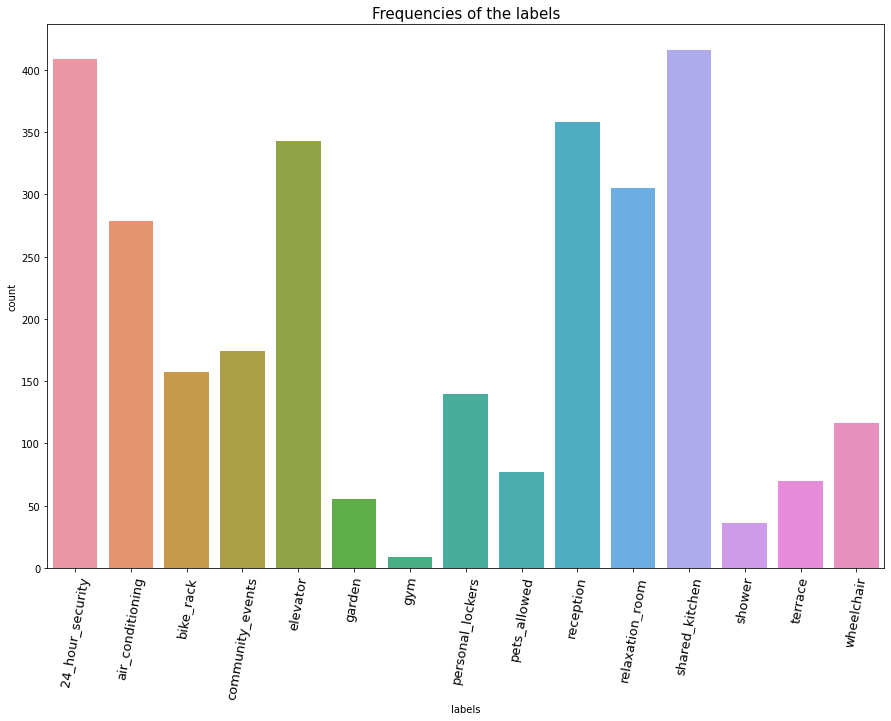

In [9]:
plot_df = pd.DataFrame(df[class_names].sum(), columns = ['count']).reset_index().rename(columns = {'index':'labels'})
plt.figure(figsize = (15, 10))
sns.barplot(plot_df['labels'], plot_df['count'])
plt.xticks(rotation = 80, size = 13)
plt.title('Frequencies of the labels', size = 15)
plt.show()

Splitting the offices.

In [10]:
def train_test_split_off(df, num_train_offices, num_valid_offices, num_test_offices, seed):

  np.random.seed(seed)

  train_offices = np.random.choice(df['location_id'], num_train_offices, replace = False)
  valid_offices = np.random.choice(df[~df['location_id'].isin(train_offices)]['location_id'], num_valid_offices, replace = False)
  test_offices = np.random.choice(df[~df['location_id'].isin(np.concatenate((train_offices, valid_offices)))]['location_id'], num_test_offices, replace = False)

  return (train_offices, valid_offices, test_offices)

In [11]:
train_offices, valid_offices, test_offices = train_test_split_off(df, num_train_offices, num_valid_offices, num_test_offices, seed)

print(f'number of offices in training set: {len(train_offices)}')
print(f'number of offices in validation set: {len(valid_offices)}')
print(f'number of offices in test set: {len(test_offices)}')

number of offices in training set: 300
number of offices in validation set: 79
number of offices in test set: 78


Loading and storing the offices' pictures as 3D arrays and the numbers of pictures per office.

In [12]:
def load_images(offices):

    #initializing the lists for storing both pictures and number of pictures for each office.
    imgs = []
    num_pics = []

    #for each office, load and store all the pictures and the number of pictures into respective lists.
    for off in offices:

        folder_path = f'/content/gdrive/MyDrive/office_data/photos/office_{off}/'

        i = 0

        for img_name in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, img_name))

            if img is not None:

                imgs.append(img)
                i += 1

        num_pics.append(i)

    return imgs, num_pics

In [13]:
train_imgs, train_num_pics = load_images(train_offices)
print(f'number of pictures in training set: {sum(train_num_pics)}')

number of pictures in training set: 1657


In [14]:
valid_imgs, valid_num_pics = load_images(valid_offices)
print(f'number of pictures in validation set: {sum(valid_num_pics)}')

number of pictures in validation set: 438


In [15]:
test_imgs, test_num_pics = load_images(test_offices)
print(f'number of pictures in test set: {sum(test_num_pics)}')

number of pictures in test set: 408


In [16]:
train_valid_imgs, train_valid_num_pics = train_imgs + valid_imgs, train_num_pics + valid_num_pics
print(f'number of pictures in joind training and validation set: {sum(train_valid_num_pics)}')

number of pictures in joind training and validation set: 2095


Processing of images including resizing, normalization and conversion of numpy arrays into tensors.

In [17]:
def prep_images(imgs, resize_dim = 100, normalization = True, tf_conversion = True):

    prep_images = []

    for img in imgs:
        res_norm_img = cv2.resize(img, (resize_dim, resize_dim)) #resizing the pictures.
        prep_images.append(res_norm_img)
    
    if normalization:
        prep_images = [img/255.0 for img in prep_images] #normalizing the pictures.

    if tf_conversion:
        prep_images = tf.stack(prep_images) #conversion of numpy arrays into tensors.

    return prep_images

In [18]:
train_tf_imgs = prep_images(train_imgs, resize_dim = dim_size, normalization = True, tf_conversion = True)

In [19]:
valid_tf_imgs = prep_images(valid_imgs, resize_dim = dim_size, normalization = True, tf_conversion = True)

In [20]:
test_tf_imgs = prep_images(test_imgs, resize_dim = dim_size, normalization = True, tf_conversion = True)

In [21]:
train_valid_tf_imgs = prep_images(train_valid_imgs, resize_dim = dim_size, normalization = True, tf_conversion = True)

In [22]:
print(f'training shape: {train_tf_imgs.shape}')
print(f'validation shape: {valid_tf_imgs.shape}')
print(f'test shape: {test_tf_imgs.shape}')
print(f'joined training and validation shape: {train_valid_tf_imgs.shape}')

training shape: (1657, 100, 100, 3)
validation shape: (438, 100, 100, 3)
test shape: (408, 100, 100, 3)
joined training and validation shape: (2095, 100, 100, 3)


Processing of the classes/labels.

In [23]:
def prep_labels(df, offices, num_pics):

    #initializing a data frame for storing the labels/classes for each office.
    labels_df = pd.DataFrame(columns = list(df.columns)[1:])

    #since we don't have the labels for each picture but rather for each office instead, we gonna replicate the labels for all pictures per office.

    #for each ffice, replicate the labels for all pictures of given office.
    for num, pic in zip(num_pics, offices): #for each office (with corresponding number of pictures)
        for _ in range(num): #for each picture of given office.
            labels_row = df.query(f'location_id == {pic}').drop('location_id', axis = 1) #filter the labels of given office
            labels_df = pd.concat((labels_df, labels_row)) #store the labels into a data frame.

    #conversion of the labels from data frame into numpy arrays with subsequent conversion into tensors.
    tf_labels = tf.constant([labels_df.to_numpy()])[0]

    return tf_labels

In [24]:
train_valid_offices = np.concatenate((train_offices, valid_offices))

In [25]:
train_tf_labels = prep_labels(df, train_offices, train_num_pics)
valid_tf_labels = prep_labels(df, valid_offices, valid_num_pics)
test_tf_labels = prep_labels(df, test_offices, test_num_pics)
train_valid_tf_labels = prep_labels(df, train_valid_offices, train_valid_num_pics)

## **CNN Modelling & Bayesian Optimization**

In [26]:
def model_building(hp):

  global dim_size

  inputs = Input(shape = (dim_size, dim_size, 3))
  x = inputs

  for i in range(hp.Int('conv_blocks', min_value = 3, max_value = 5, default = 3)):
    filters = hp.Int('filters_' + str(i), min_value = 32, max_value = 256, step = 32) 
    
    for _ in range(2):

      x = Conv2D(filters, kernel_size=(3, 3), padding = 'same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)


    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
        x = MaxPooling2D()(x)
    else:
        x = AveragePooling2D()(x)
    
    x = Dropout((hp.Float('dropout', 0, 0.5, step = 0.05, default = 0.5)))(x)

  x = Flatten()(x)
  x = Dense(hp.Int('Dense units' ,min_value = 30, max_value = 100, step = 10, default = 50),
                  activation='relu')(x)

  x = Dropout((hp.Float('dropout', 0, 0.5, step = 0.05, default = 0.5)))(x)

  global class_names

  outputs = Dense(len(class_names), activation = 'sigmoid')(x)
  
  model = Model(inputs, outputs, name = 'CNN_PN')

  model.compile(optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate',
                                                              min_value = 1e-4,
                                                              max_value =1e-2,
                                                              sampling='log')), 
                loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model

In [27]:
bayes_opt = kt.tuners.BayesianOptimization(model_building, objective = 'val_loss', max_trials = 100)

In [28]:
bayes_opt.search(train_tf_imgs, train_tf_labels,
                 validation_data = (valid_tf_imgs, valid_tf_labels), 
                 epochs = 100,
                 callbacks = [EarlyStopping(patience = 69)])

Trial 100 Complete [00h 01m 47s]
val_loss: 0.46633318066596985

Best val_loss So Far: 0.45714694261550903
Total elapsed time: 04h 34m 51s


In [29]:
best_hypers = bayes_opt.get_best_hyperparameters(num_trials=1)[0]

In [30]:
display(best_hypers.values)

{'conv_blocks': 4,
 'filters_0': 96,
 'pooling_0': 'avg',
 'dropout': 0.5,
 'filters_1': 256,
 'pooling_1': 'max',
 'filters_2': 32,
 'pooling_2': 'max',
 'Dense units': 90,
 'learning_rate': 0.001918070201228995,
 'filters_3': 32,
 'pooling_3': 'max',
 'filters_4': 96,
 'pooling_4': 'max'}

In [31]:
final_model = bayes_opt.hypermodel.build(best_hypers)

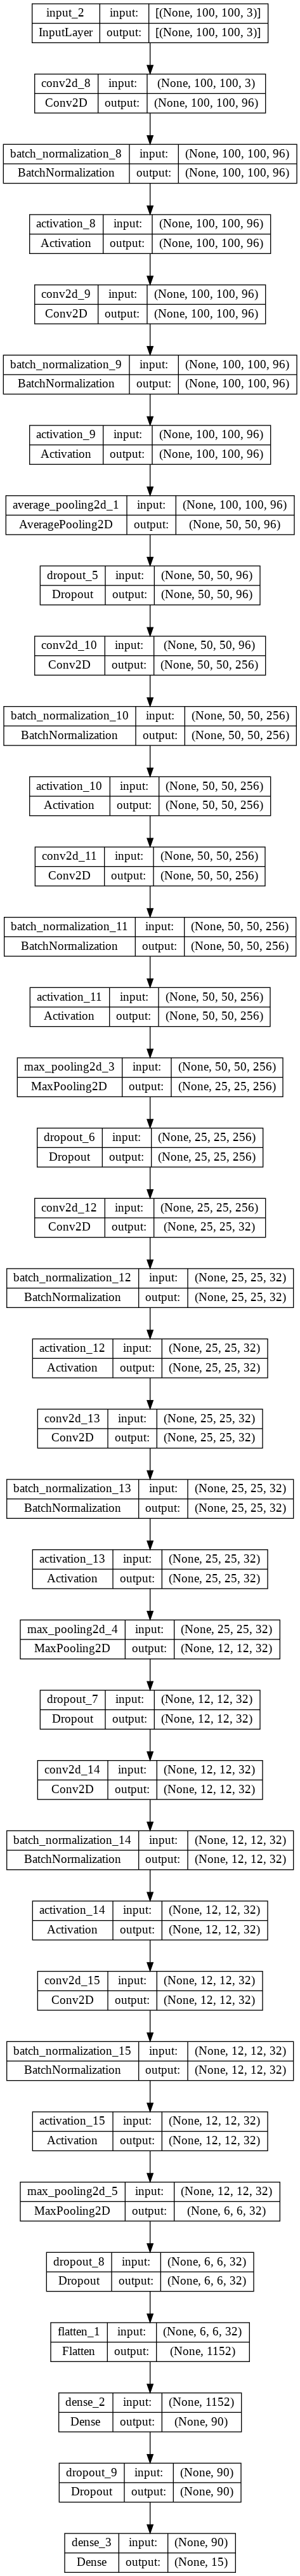

In [32]:
tf.keras.utils.plot_model(final_model, show_shapes = True,
                            show_layer_names = True, expand_nested = True)

In [33]:
final_model.summary()

Model: "CNN_PN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 96)      2688      
                                                                 
 batch_normalization_8 (Batc  (None, 100, 100, 96)     384       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 100, 100, 96)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 96)      83040     
                                                                 
 batch_normalization_9 (Batc  (None, 100, 100, 96)     384       
 hNormalization)                                            

In [34]:
history = final_model.fit(train_valid_tf_imgs, train_valid_tf_labels,
                          epochs = 100, verbose = 1,
                          callbacks = [EarlyStopping(patience = 80)])

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 0.6069 - accuracy: 0.2893

66/66 [==============================] - 3s 30ms/step - loss: 0.6069 - accuracy: 0.2893
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.3489

66/66 [==============================] - 2s 24ms/step - loss: 0.5047 - accuracy: 0.3489
Epoch 3/100
64/66 [============================>.] - ETA: 0s - loss: 0.4861 - accuracy: 0.2544

66/66 [==============================] - 2s 23ms/step - loss: 0.4852 - accuracy: 0.2511
Epoch 4/100
65/66 [============================>.] - ETA: 0s - loss: 0.4807 - accuracy: 0.1784

66/66 [==============================] - 2s 23ms/step - loss: 0.4806 - accuracy: 0.1785
Epoch 5/100
66/66 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.0926

66/66 [==============================] - 2s 24ms/step - loss: 0.4769 - accuracy: 0.0926
Epoch 6/100
66/66 [==============================] - ETA: 0s - loss: 0.4723 - accuracy: 0.1284

66/66 [==============================] - 2s 23ms/step - loss: 0.4723 - accuracy: 0.1284
Epoch 7/100
64/66 [============================>.] - ETA: 0s - loss: 0.4731 - accuracy: 0.1357

66/66 [==============================] - 2s 23ms/step - loss: 0.4731 - accuracy: 0.1341
Epoch 8/100
64/66 [============================>.] - ETA: 0s - loss: 0.4705 - accuracy: 0.1348

66/66 [==============================] - 2s 23ms/step - loss: 0.4699 - accuracy: 0.1360
Epoch 9/100
64/66 [============================>.] - ETA: 0s - loss: 0.4669 - accuracy: 0.0908

66/66 [==============================] - 2s 23ms/step - loss: 0.4658 - accuracy: 0.0888
Epoch 10/100
64/66 [============================>.] - ETA: 0s - loss: 0.4641 - accuracy: 0.0757

66/66 [==============================] - 2s 23ms/step - loss: 0.4624 - accuracy: 0.0773
Epoch 11/100
64/66 [============================>.] - ETA: 0s - loss: 0.4630 - accuracy: 0.0698

66/66 [==============================] - 2s 23ms/step - loss: 0.4628 - accuracy: 0.0702
Epoch 12/100
64/66 [============================>.] - ETA: 0s - loss: 0.4585 - accuracy: 0.1084

66/66 [==============================] - 2s 23ms/step - loss: 0.4587 - accuracy: 0.1074
Epoch 13/100
64/66 [============================>.] - ETA: 0s - loss: 0.4590 - accuracy: 0.0586

66/66 [==============================] - 2s 23ms/step - loss: 0.4593 - accuracy: 0.0582
Epoch 14/100
66/66 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.0621

66/66 [==============================] - 2s 23ms/step - loss: 0.4565 - accuracy: 0.0621
Epoch 15/100
64/66 [============================>.] - ETA: 0s - loss: 0.4557 - accuracy: 0.0571

66/66 [==============================] - 2s 23ms/step - loss: 0.4570 - accuracy: 0.0587
Epoch 16/100
64/66 [============================>.] - ETA: 0s - loss: 0.4522 - accuracy: 0.0654

66/66 [==============================] - 2s 23ms/step - loss: 0.4530 - accuracy: 0.0654
Epoch 17/100
64/66 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.0591

66/66 [==============================] - 2s 23ms/step - loss: 0.4499 - accuracy: 0.0587
Epoch 18/100
64/66 [============================>.] - ETA: 0s - loss: 0.4529 - accuracy: 0.1016

66/66 [==============================] - 2s 23ms/step - loss: 0.4530 - accuracy: 0.1002
Epoch 19/100
64/66 [============================>.] - ETA: 0s - loss: 0.4503 - accuracy: 0.0356

66/66 [==============================] - 2s 23ms/step - loss: 0.4507 - accuracy: 0.0353
Epoch 20/100
64/66 [============================>.] - ETA: 0s - loss: 0.4487 - accuracy: 0.0439

66/66 [==============================] - 2s 23ms/step - loss: 0.4483 - accuracy: 0.0449
Epoch 21/100
64/66 [============================>.] - ETA: 0s - loss: 0.4463 - accuracy: 0.0913

66/66 [==============================] - 2s 23ms/step - loss: 0.4454 - accuracy: 0.0912
Epoch 22/100
64/66 [============================>.] - ETA: 0s - loss: 0.4500 - accuracy: 0.0459

66/66 [==============================] - 2s 23ms/step - loss: 0.4497 - accuracy: 0.0458
Epoch 23/100
64/66 [============================>.] - ETA: 0s - loss: 0.4497 - accuracy: 0.0645

66/66 [==============================] - 2s 23ms/step - loss: 0.4481 - accuracy: 0.0635
Epoch 24/100
66/66 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.0649

66/66 [==============================] - 2s 23ms/step - loss: 0.4446 - accuracy: 0.0649
Epoch 25/100
64/66 [============================>.] - ETA: 0s - loss: 0.4438 - accuracy: 0.0645

66/66 [==============================] - 2s 23ms/step - loss: 0.4432 - accuracy: 0.0635
Epoch 26/100
64/66 [============================>.] - ETA: 0s - loss: 0.4407 - accuracy: 0.0479

66/66 [==============================] - 2s 23ms/step - loss: 0.4411 - accuracy: 0.0477
Epoch 27/100
64/66 [============================>.] - ETA: 0s - loss: 0.4439 - accuracy: 0.0508

66/66 [==============================] - 2s 23ms/step - loss: 0.4424 - accuracy: 0.0506
Epoch 28/100
64/66 [============================>.] - ETA: 0s - loss: 0.4398 - accuracy: 0.0410

66/66 [==============================] - 2s 23ms/step - loss: 0.4395 - accuracy: 0.0406
Epoch 29/100
64/66 [============================>.] - ETA: 0s - loss: 0.4379 - accuracy: 0.0376

66/66 [==============================] - 2s 23ms/step - loss: 0.4388 - accuracy: 0.0382
Epoch 30/100
64/66 [============================>.] - ETA: 0s - loss: 0.4405 - accuracy: 0.0576

66/66 [==============================] - 2s 23ms/step - loss: 0.4401 - accuracy: 0.0573
Epoch 31/100
66/66 [==============================] - ETA: 0s - loss: 0.4380 - accuracy: 0.0425

66/66 [==============================] - 2s 24ms/step - loss: 0.4380 - accuracy: 0.0425
Epoch 32/100
64/66 [============================>.] - ETA: 0s - loss: 0.4365 - accuracy: 0.0415

66/66 [==============================] - 2s 23ms/step - loss: 0.4376 - accuracy: 0.0415
Epoch 33/100
64/66 [============================>.] - ETA: 0s - loss: 0.4352 - accuracy: 0.0615

66/66 [==============================] - 2s 23ms/step - loss: 0.4345 - accuracy: 0.0611
Epoch 34/100
64/66 [============================>.] - ETA: 0s - loss: 0.4333 - accuracy: 0.0664

66/66 [==============================] - 2s 23ms/step - loss: 0.4336 - accuracy: 0.0663
Epoch 35/100
64/66 [============================>.] - ETA: 0s - loss: 0.4310 - accuracy: 0.0605

66/66 [==============================] - 2s 23ms/step - loss: 0.4304 - accuracy: 0.0606
Epoch 36/100
64/66 [============================>.] - ETA: 0s - loss: 0.4332 - accuracy: 0.0640

66/66 [==============================] - 2s 23ms/step - loss: 0.4333 - accuracy: 0.0625
Epoch 37/100
64/66 [============================>.] - ETA: 0s - loss: 0.4333 - accuracy: 0.0552

66/66 [==============================] - 2s 23ms/step - loss: 0.4332 - accuracy: 0.0554
Epoch 38/100
64/66 [============================>.] - ETA: 0s - loss: 0.4284 - accuracy: 0.0859

66/66 [==============================] - 2s 23ms/step - loss: 0.4292 - accuracy: 0.0878
Epoch 39/100
64/66 [============================>.] - ETA: 0s - loss: 0.4292 - accuracy: 0.0566

66/66 [==============================] - 2s 23ms/step - loss: 0.4298 - accuracy: 0.0592
Epoch 40/100
64/66 [============================>.] - ETA: 0s - loss: 0.4310 - accuracy: 0.0645

66/66 [==============================] - 2s 23ms/step - loss: 0.4312 - accuracy: 0.0635
Epoch 41/100
64/66 [============================>.] - ETA: 0s - loss: 0.4298 - accuracy: 0.0591

66/66 [==============================] - 2s 23ms/step - loss: 0.4286 - accuracy: 0.0592
Epoch 42/100
64/66 [============================>.] - ETA: 0s - loss: 0.4295 - accuracy: 0.0835

66/66 [==============================] - 2s 23ms/step - loss: 0.4294 - accuracy: 0.0831
Epoch 43/100
66/66 [==============================] - ETA: 0s - loss: 0.4236 - accuracy: 0.0778

66/66 [==============================] - 2s 24ms/step - loss: 0.4236 - accuracy: 0.0778
Epoch 44/100
64/66 [============================>.] - ETA: 0s - loss: 0.4236 - accuracy: 0.0840

66/66 [==============================] - 2s 23ms/step - loss: 0.4236 - accuracy: 0.0835
Epoch 45/100
64/66 [============================>.] - ETA: 0s - loss: 0.4249 - accuracy: 0.0547

66/66 [==============================] - 2s 23ms/step - loss: 0.4253 - accuracy: 0.0535
Epoch 46/100
64/66 [============================>.] - ETA: 0s - loss: 0.4213 - accuracy: 0.0576

66/66 [==============================] - 2s 23ms/step - loss: 0.4214 - accuracy: 0.0587
Epoch 47/100
66/66 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.0888

66/66 [==============================] - 2s 23ms/step - loss: 0.4235 - accuracy: 0.0888
Epoch 48/100
64/66 [============================>.] - ETA: 0s - loss: 0.4256 - accuracy: 0.0293

66/66 [==============================] - 2s 23ms/step - loss: 0.4255 - accuracy: 0.0291
Epoch 49/100
64/66 [============================>.] - ETA: 0s - loss: 0.4260 - accuracy: 0.0737

66/66 [==============================] - 2s 23ms/step - loss: 0.4260 - accuracy: 0.0740
Epoch 50/100
64/66 [============================>.] - ETA: 0s - loss: 0.4231 - accuracy: 0.0513

66/66 [==============================] - 2s 23ms/step - loss: 0.4240 - accuracy: 0.0506
Epoch 51/100
64/66 [============================>.] - ETA: 0s - loss: 0.4195 - accuracy: 0.0728

66/66 [==============================] - 2s 23ms/step - loss: 0.4186 - accuracy: 0.0716
Epoch 52/100
64/66 [============================>.] - ETA: 0s - loss: 0.4171 - accuracy: 0.0864

66/66 [==============================] - 2s 23ms/step - loss: 0.4181 - accuracy: 0.0864
Epoch 53/100
64/66 [============================>.] - ETA: 0s - loss: 0.4187 - accuracy: 0.0513

66/66 [==============================] - 2s 23ms/step - loss: 0.4199 - accuracy: 0.0506
Epoch 54/100
64/66 [============================>.] - ETA: 0s - loss: 0.4201 - accuracy: 0.0708

66/66 [==============================] - 2s 23ms/step - loss: 0.4196 - accuracy: 0.0692
Epoch 55/100
64/66 [============================>.] - ETA: 0s - loss: 0.4168 - accuracy: 0.0698

66/66 [==============================] - 2s 23ms/step - loss: 0.4163 - accuracy: 0.0697
Epoch 56/100
64/66 [============================>.] - ETA: 0s - loss: 0.4180 - accuracy: 0.0742

66/66 [==============================] - 2s 23ms/step - loss: 0.4172 - accuracy: 0.0745
Epoch 57/100
66/66 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.1069

66/66 [==============================] - 2s 23ms/step - loss: 0.4179 - accuracy: 0.1069
Epoch 58/100
64/66 [============================>.] - ETA: 0s - loss: 0.4182 - accuracy: 0.0405

66/66 [==============================] - 2s 23ms/step - loss: 0.4163 - accuracy: 0.0420
Epoch 59/100
64/66 [============================>.] - ETA: 0s - loss: 0.4145 - accuracy: 0.0581

66/66 [==============================] - 2s 23ms/step - loss: 0.4136 - accuracy: 0.0573
Epoch 60/100
64/66 [============================>.] - ETA: 0s - loss: 0.4132 - accuracy: 0.0498

66/66 [==============================] - 2s 23ms/step - loss: 0.4127 - accuracy: 0.0511
Epoch 61/100
66/66 [==============================] - ETA: 0s - loss: 0.4140 - accuracy: 0.0578

66/66 [==============================] - 2s 23ms/step - loss: 0.4140 - accuracy: 0.0578
Epoch 62/100
64/66 [============================>.] - ETA: 0s - loss: 0.4151 - accuracy: 0.0596

66/66 [==============================] - 2s 23ms/step - loss: 0.4155 - accuracy: 0.0592
Epoch 63/100
64/66 [============================>.] - ETA: 0s - loss: 0.4107 - accuracy: 0.0601

66/66 [==============================] - 2s 23ms/step - loss: 0.4102 - accuracy: 0.0592
Epoch 64/100
64/66 [============================>.] - ETA: 0s - loss: 0.4117 - accuracy: 0.0439

66/66 [==============================] - 2s 23ms/step - loss: 0.4092 - accuracy: 0.0444
Epoch 65/100
64/66 [============================>.] - ETA: 0s - loss: 0.4089 - accuracy: 0.0376

66/66 [==============================] - 2s 23ms/step - loss: 0.4099 - accuracy: 0.0372
Epoch 66/100
66/66 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.0516

66/66 [==============================] - 2s 24ms/step - loss: 0.4082 - accuracy: 0.0516
Epoch 67/100
65/66 [============================>.] - ETA: 0s - loss: 0.4044 - accuracy: 0.0337

66/66 [==============================] - 2s 24ms/step - loss: 0.4044 - accuracy: 0.0334
Epoch 68/100
66/66 [==============================] - ETA: 0s - loss: 0.4057 - accuracy: 0.0606

66/66 [==============================] - 2s 24ms/step - loss: 0.4057 - accuracy: 0.0606
Epoch 69/100
64/66 [============================>.] - ETA: 0s - loss: 0.4090 - accuracy: 0.0742

66/66 [==============================] - 2s 24ms/step - loss: 0.4095 - accuracy: 0.0749
Epoch 70/100
64/66 [============================>.] - ETA: 0s - loss: 0.4069 - accuracy: 0.0757

66/66 [==============================] - 2s 23ms/step - loss: 0.4072 - accuracy: 0.0754
Epoch 71/100
64/66 [============================>.] - ETA: 0s - loss: 0.4029 - accuracy: 0.0654

66/66 [==============================] - 2s 23ms/step - loss: 0.4031 - accuracy: 0.0649
Epoch 72/100
64/66 [============================>.] - ETA: 0s - loss: 0.4029 - accuracy: 0.0513

66/66 [==============================] - 2s 23ms/step - loss: 0.4029 - accuracy: 0.0516
Epoch 73/100
64/66 [============================>.] - ETA: 0s - loss: 0.4059 - accuracy: 0.0684

66/66 [==============================] - 2s 23ms/step - loss: 0.4061 - accuracy: 0.0687
Epoch 74/100
64/66 [============================>.] - ETA: 0s - loss: 0.4033 - accuracy: 0.0537

66/66 [==============================] - 2s 23ms/step - loss: 0.4036 - accuracy: 0.0554
Epoch 75/100
64/66 [============================>.] - ETA: 0s - loss: 0.4008 - accuracy: 0.0625

66/66 [==============================] - 2s 23ms/step - loss: 0.4003 - accuracy: 0.0621
Epoch 76/100
64/66 [============================>.] - ETA: 0s - loss: 0.4003 - accuracy: 0.0630

66/66 [==============================] - 2s 23ms/step - loss: 0.4010 - accuracy: 0.0621
Epoch 77/100
64/66 [============================>.] - ETA: 0s - loss: 0.4023 - accuracy: 0.0337

66/66 [==============================] - 2s 23ms/step - loss: 0.4019 - accuracy: 0.0339
Epoch 78/100
64/66 [============================>.] - ETA: 0s - loss: 0.4047 - accuracy: 0.0415

66/66 [==============================] - 2s 23ms/step - loss: 0.4054 - accuracy: 0.0420
Epoch 79/100
64/66 [============================>.] - ETA: 0s - loss: 0.4015 - accuracy: 0.0435

66/66 [==============================] - 2s 23ms/step - loss: 0.4011 - accuracy: 0.0425
Epoch 80/100
64/66 [============================>.] - ETA: 0s - loss: 0.4020 - accuracy: 0.0459

66/66 [==============================] - 2s 23ms/step - loss: 0.4016 - accuracy: 0.0453
Epoch 81/100
64/66 [============================>.] - ETA: 0s - loss: 0.3961 - accuracy: 0.0435

66/66 [==============================] - 2s 23ms/step - loss: 0.3956 - accuracy: 0.0425
Epoch 82/100
66/66 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.0955

66/66 [==============================] - 2s 23ms/step - loss: 0.3996 - accuracy: 0.0955
Epoch 83/100
66/66 [==============================] - ETA: 0s - loss: 0.4009 - accuracy: 0.0587

66/66 [==============================] - 2s 23ms/step - loss: 0.4009 - accuracy: 0.0587
Epoch 84/100
64/66 [============================>.] - ETA: 0s - loss: 0.3986 - accuracy: 0.0820

66/66 [==============================] - 2s 23ms/step - loss: 0.3989 - accuracy: 0.0811
Epoch 85/100
64/66 [============================>.] - ETA: 0s - loss: 0.3945 - accuracy: 0.0825

66/66 [==============================] - 2s 23ms/step - loss: 0.3953 - accuracy: 0.0811
Epoch 86/100
64/66 [============================>.] - ETA: 0s - loss: 0.4000 - accuracy: 0.0654

66/66 [==============================] - 2s 23ms/step - loss: 0.3996 - accuracy: 0.0654
Epoch 87/100
64/66 [============================>.] - ETA: 0s - loss: 0.3937 - accuracy: 0.0454

66/66 [==============================] - 2s 23ms/step - loss: 0.3944 - accuracy: 0.0453
Epoch 88/100
64/66 [============================>.] - ETA: 0s - loss: 0.3960 - accuracy: 0.0703

66/66 [==============================] - 2s 23ms/step - loss: 0.3960 - accuracy: 0.0702
Epoch 89/100
64/66 [============================>.] - ETA: 0s - loss: 0.3951 - accuracy: 0.0635

66/66 [==============================] - 2s 23ms/step - loss: 0.3946 - accuracy: 0.0635
Epoch 90/100
64/66 [============================>.] - ETA: 0s - loss: 0.3928 - accuracy: 0.0811

66/66 [==============================] - 2s 23ms/step - loss: 0.3930 - accuracy: 0.0811
Epoch 91/100
64/66 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.0522

66/66 [==============================] - 2s 23ms/step - loss: 0.3909 - accuracy: 0.0511
Epoch 92/100
64/66 [============================>.] - ETA: 0s - loss: 0.3885 - accuracy: 0.0513

66/66 [==============================] - 2s 23ms/step - loss: 0.3894 - accuracy: 0.0506
Epoch 93/100
64/66 [============================>.] - ETA: 0s - loss: 0.3886 - accuracy: 0.0791

66/66 [==============================] - 2s 23ms/step - loss: 0.3885 - accuracy: 0.0797
Epoch 94/100
64/66 [============================>.] - ETA: 0s - loss: 0.3919 - accuracy: 0.0532

66/66 [==============================] - 2s 24ms/step - loss: 0.3919 - accuracy: 0.0530
Epoch 95/100
64/66 [============================>.] - ETA: 0s - loss: 0.3900 - accuracy: 0.0527

66/66 [==============================] - 2s 23ms/step - loss: 0.3895 - accuracy: 0.0535
Epoch 96/100
64/66 [============================>.] - ETA: 0s - loss: 0.3864 - accuracy: 0.0693

66/66 [==============================] - 2s 23ms/step - loss: 0.3869 - accuracy: 0.0687
Epoch 97/100
64/66 [============================>.] - ETA: 0s - loss: 0.3873 - accuracy: 0.0386

66/66 [==============================] - 2s 23ms/step - loss: 0.3869 - accuracy: 0.0396
Epoch 98/100
64/66 [============================>.] - ETA: 0s - loss: 0.3890 - accuracy: 0.0796

66/66 [==============================] - 2s 23ms/step - loss: 0.3881 - accuracy: 0.0802
Epoch 99/100
64/66 [============================>.] - ETA: 0s - loss: 0.3862 - accuracy: 0.0493

66/66 [==============================] - 2s 23ms/step - loss: 0.3860 - accuracy: 0.0482
Epoch 100/100
64/66 [============================>.] - ETA: 0s - loss: 0.3819 - accuracy: 0.0664

66/66 [==============================] - 2s 23ms/step - loss: 0.3824 - accuracy: 0.0668


In [98]:
final_model.save('CNN_PN.h5')

# **Evaluation**

Dictionary of offices and their images' indices.

In [35]:
def office_indexing(offices, num_pics):
    offices_dict = {}

    k = 0 #initializing an index
    ind_list = [] # initializing a list for storing starting and ending indices per each office.

    for office, no_pic in zip(offices, num_pics):
        #k is an starting index for given office
            #an ending index is the starting index incremented by the number of pictures of given office.
            #since the Python indexing starts from 0, we need to decrease the the ending index by 1.
        ind_list = [k, k+no_pic-1] 
        offices_dict[office] = ind_list
        #adjusting the starting index for next office by incremeting the index by number of pictures of the previous office.
        k += no_pic

    return offices_dict

In [36]:
train_offices_dict = office_indexing(train_offices, train_num_pics)
valid_offices_dict = office_indexing(valid_offices, valid_num_pics)
test_offices_dict = office_indexing(test_offices, test_num_pics)

Choosing a single office(s) for further single evaluation(s).

In [37]:
single_train_office = np.random.choice(train_offices, 1)[0]
single_valid_office = np.random.choice(valid_offices, 1)[0]
single_test_office = np.random.choice(test_offices, 1)[0]

Plotting the pictures of given office.

In [38]:
def plot_office(office):
    path_pic =  f'/content/gdrive/MyDrive/office_data/photos/office_{office}/'

    for pic in os.listdir(path_pic):
        img = cv2.imread(os.path.join(path_pic, pic))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Office {office} ({os.path.join(path_pic, pic).split("/")[-1]})', size = 15)
        plt.show()

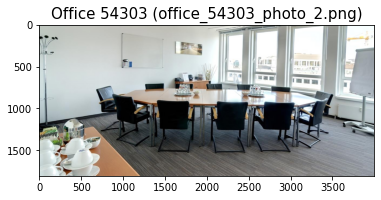

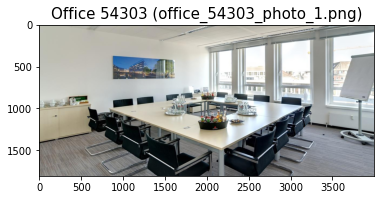

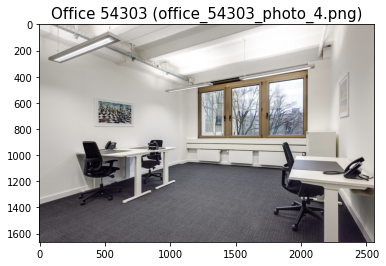

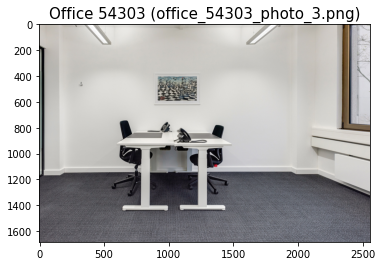

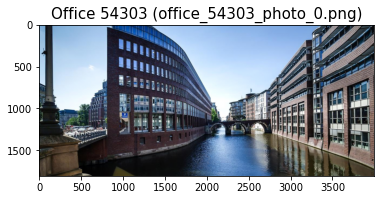

In [39]:
plot_office(single_train_office)

Class predictions based on the trained model, for given office.

In [40]:
def office_predictions(model, tf_imgs, offices_dict, office):
    
    start_ind = min(offices_dict[office])
    end_ind = max(offices_dict[office]) + 1

    office_probs= model.predict(tf_imgs[start_ind:end_ind])

    return office_probs

In [41]:
single_train_office_preds = office_predictions(final_model, train_tf_imgs, train_offices_dict, single_train_office)
single_valid_office_preds = office_predictions(final_model, valid_tf_imgs, valid_offices_dict, single_valid_office)
single_test_office_preds = office_predictions(final_model, test_tf_imgs, test_offices_dict, single_test_office)

1/1 [==============================] - 0s 18ms/step


Evaluation of the single office's predictions based on predicted probabilites.

In [42]:
def office_evaluation(predictions, class_names, df, office):
    #storing predicted probabilites and the the class names into a data frame.
    eval_df = pd.DataFrame(pd.DataFrame(predictions, columns = class_names).mean(),
                           columns = ['prob']).reset_index().rename(columns = {'index':'var'})

    #classification based on probabilities with a default threshold 0.5.
    eval_df['pred'] = eval_df['prob'].apply(lambda x: 1 if x > 0.5 else 0)
    
    #joining the predicted classes with the true classes.
    eval_df = pd.concat((eval_df,
                        pd.DataFrame(df[df['location_id'] == office].drop('location_id', axis = 1).values).transpose()),
                        axis=1).rename(columns = {'index':'var', 0:'true'})

    #indicator whether the predicted class is the same as the true class.
    eval_df['outcome'] = [1 if i == j else 0 for i, j in zip(eval_df['pred'], eval_df['true'])]

    return eval_df

In [43]:
single_train_eval_df = office_evaluation(single_train_office_preds, class_names, df, single_train_office)
single_valid_eval_df = office_evaluation(single_valid_office_preds, class_names, df, single_train_office)
single_test_eval_df = office_evaluation(single_test_office_preds, class_names, df, single_train_office)

In [44]:
display(single_train_eval_df)

,var,prob,pred,true,outcome
0,24_hour_security,0.958096,1,1,1
1,air_conditioning,0.808969,1,1,1
2,bike_rack,0.157295,0,0,1
3,community_events,0.179316,0,0,1
4,elevator,0.902857,1,1,1
5,garden,0.037491,0,0,1
6,gym,0.000918,0,0,1
7,personal_lockers,0.174352,0,0,1
8,pets_allowed,0.035617,0,0,1
9,reception,0.907237,1,1,1


In [45]:
display(single_valid_eval_df)

,var,prob,pred,true,outcome
0,24_hour_security,0.989613,1,1,1
1,air_conditioning,0.904442,1,1,1
2,bike_rack,0.829791,1,0,0
3,community_events,0.852730,1,0,0
4,elevator,0.956145,1,1,1
5,garden,0.276465,0,0,1
6,gym,0.005352,0,0,1
7,personal_lockers,0.314257,0,0,1
8,pets_allowed,0.143342,0,0,1
9,reception,0.935361,1,1,1


In [46]:
display(single_test_eval_df)

,var,prob,pred,true,outcome
0,24_hour_security,0.970797,1,1,1
1,air_conditioning,0.862374,1,1,1
2,bike_rack,0.035654,0,0,1
3,community_events,0.052914,0,0,1
4,elevator,0.924150,1,1,1
5,garden,0.004869,0,0,1
6,gym,0.000099,0,0,1
7,personal_lockers,0.088073,0,0,1
8,pets_allowed,0.002965,0,0,1
9,reception,0.939049,1,1,1


Plotting the probabilities per each class/label for given office.
- what is being above the threshold (red line), it is prediction/classification as 1, else 0.
- what is being colored as an orange bar, the true label is 1.
- what is being colored as a green bar, the true label is 0.
- the desire outcome is either the orange bar being above the threshold and/or green bar being below the threshold.

In [47]:
def plot_office_evaluation(eval_df, office):
    plt.figure(figsize=(25,10))
    sns.barplot(data = eval_df, x = 'var',y='prob', hue = 'true', palette = 'Set2')
    plt.axhline(y = 0.5, color = 'r', linestyle = '-')
    plt.xticks(rotation = 45, size = 13)
    plt.yticks(size = 13)
    plt.title(f'office {office} .... average accuracy = {round(eval_df.outcome.sum()/eval_df.shape[0], 4)}', size = 17)
    plt.ylim(0.0, 1.0+.05)
    plt.show()

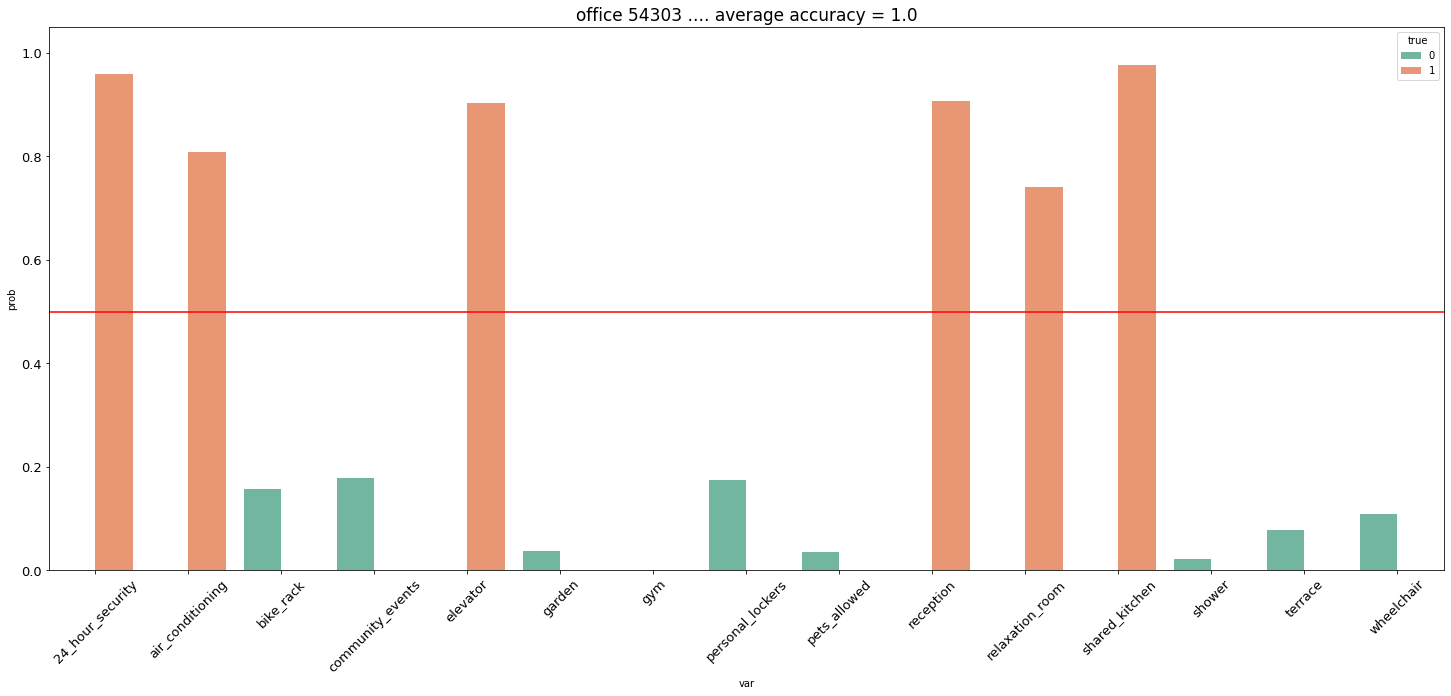

In [48]:
plot_office_evaluation(single_train_eval_df, single_train_office)

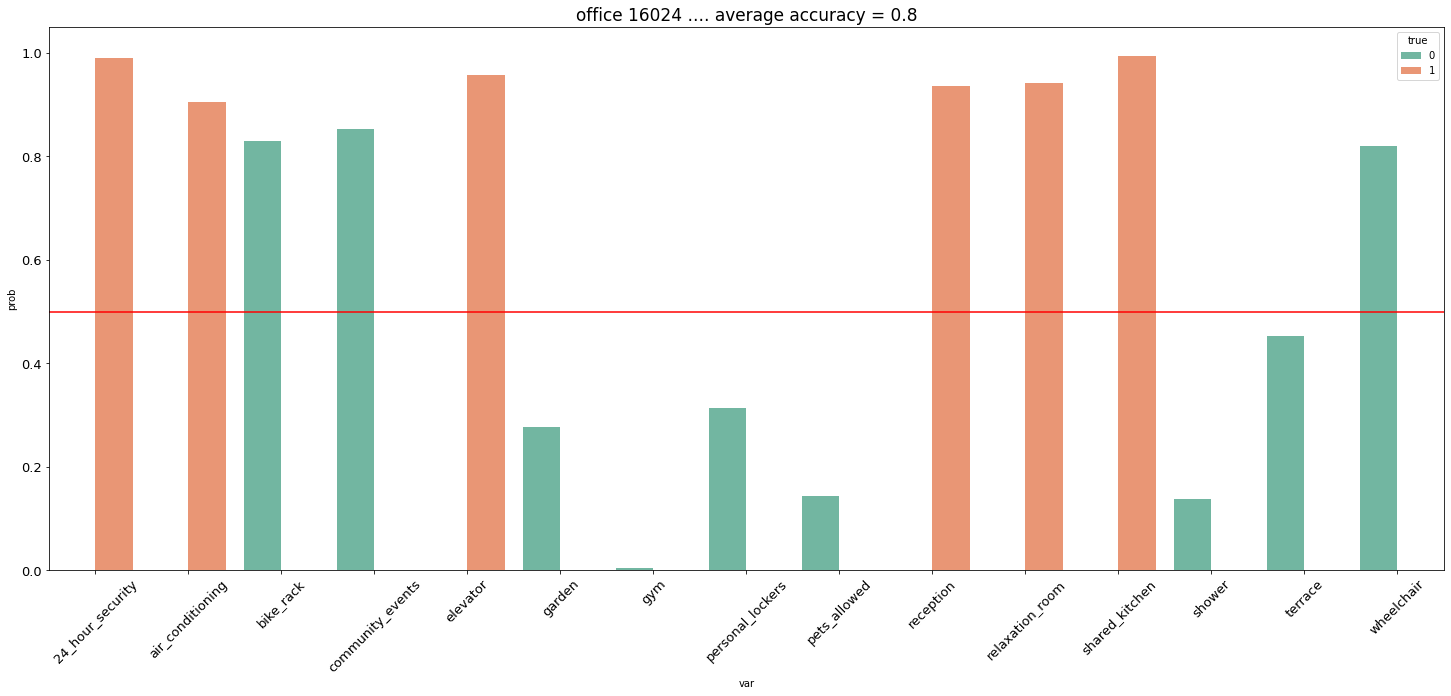

In [49]:
plot_office_evaluation(single_valid_eval_df, single_valid_office)

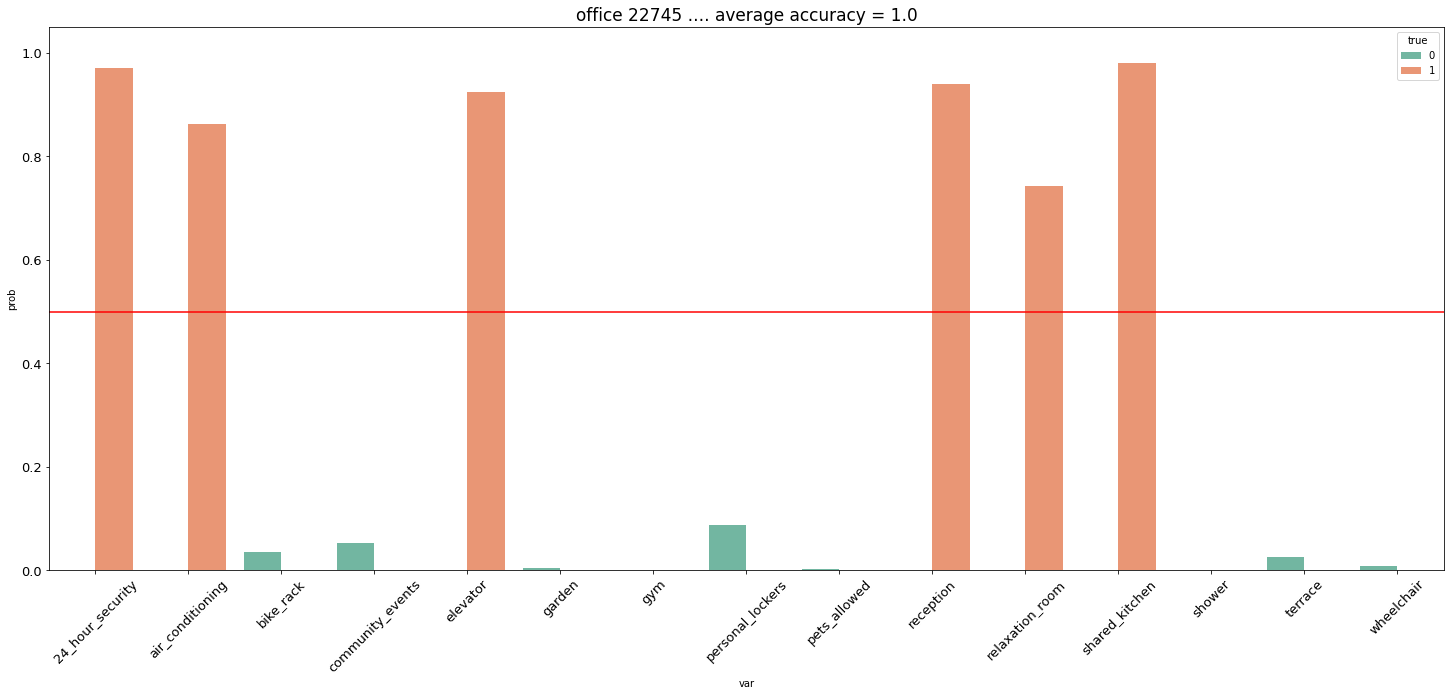

In [50]:
plot_office_evaluation(single_test_eval_df, single_test_office)

Predictions on the whole training/validation/test set.

In [51]:
train_all_predictions = final_model.predict(train_tf_imgs)

52/52 [==============================] - 0s 8ms/step


In [52]:
valid_all_predictions = final_model.predict(valid_tf_imgs)

14/14 [==============================] - 0s 7ms/step


In [53]:
test_all_predictions = final_model.predict(test_tf_imgs)

13/13 [==============================] - 0s 20ms/step


Evaluation of the model on the given set/sample.
- based on predicted probabilities, we average them per office, in order to get agregated probabililites per each office.
- based on agregated probabilities per office, we classify them with a default threshold 0.5 in order to get the predicted classes.
- based on the predicted classes per office, we compare them with the true classes per office.
- based on the comparison, we create an indicator whether the predicted classes are the same as the true classes per office (if they're the same 1, else 0).
- based on the indicators, we calculate the accuracy as a ratio of correctly predicted offices (sum of 1) with respect to the total number of offices.

In [54]:
def overall_evaluation(predictions, df, class_names, num_pics, offices):

    #data frame for storing true classes.
    true_df = pd.DataFrame(columns = list(df.columns))
    for num, pic in zip(num_pics, offices):
        for i in range(num):
            true_row = df.query(f'location_id == {pic}')
            true_df = pd.concat((true_df, true_row))

    #data frame for storing predicted classes based on probabilities.
    pred_df = pd.DataFrame(pd.DataFrame(predictions, columns = [f'{c}_prob' for c in class_names]))
    for c in class_names:
        pred_df[c] = pred_df[f'{c}_prob'].apply(lambda x: 1 if x > 0.5 else 0)
    
    #assigning the offices' names to each row.
    pred_df = pd.concat((true_df.reset_index()[['location_id']], pred_df), axis=1)

    #aggregating the probabilities by the offices.
    pred_df = pred_df.groupby('location_id')[class_names].mean().reset_index()
    
    #joining the predicted classes with the true classes.
    joined_df = pred_df.merge(df[df['location_id'].isin(offices)], on ='location_id', suffixes=('_pred','_true'))
    
    #indicator whether the predicted clases are the same as the true classes
    for c in class_names:
        joined_df[f'{c}_outcome'] = [1 if m == n else 0 for m,n in zip(joined_df[f'{c}_pred'], joined_df[f'{c}_true'])]

    #extracting only the indicators whether the predict the correct classes.
    eval_df = joined_df[[j for j in joined_df.columns if j.split('_')[-1] == 'outcome']]

    #aggregating accuracies for all classes.
    eval_df = pd.DataFrame(eval_df.mean()).reset_index().rename(columns = {'index':'var', 0:'aggregated_accuracy'})

    return eval_df

In [55]:
train_overall_ev_df = overall_evaluation(train_all_predictions, df, class_names, train_num_pics, train_offices)
valid_overall_ev_df = overall_evaluation(valid_all_predictions, df, class_names, valid_num_pics, valid_offices)
test_overall_ev_df = overall_evaluation(test_all_predictions, df, class_names, test_num_pics, test_offices)

In [56]:
display(train_overall_ev_df)

,var,aggregated_accuracy
0,24_hour_security_outcome,0.890000
1,air_conditioning_outcome,0.506667
2,bike_rack_outcome,0.616667
3,community_events_outcome,0.593333
4,elevator_outcome,0.766667
5,garden_outcome,0.873333
6,gym_outcome,0.986667
7,personal_lockers_outcome,0.666667
8,pets_allowed_outcome,0.850000
9,reception_outcome,0.826667


In [57]:
display(valid_overall_ev_df)

,var,aggregated_accuracy
0,24_hour_security_outcome,0.873418
1,air_conditioning_outcome,0.481013
2,bike_rack_outcome,0.683544
3,community_events_outcome,0.607595
4,elevator_outcome,0.708861
5,garden_outcome,0.873418
6,gym_outcome,0.987342
7,personal_lockers_outcome,0.683544
8,pets_allowed_outcome,0.797468
9,reception_outcome,0.708861


In [58]:
display(test_overall_ev_df)

,var,aggregated_accuracy
0,24_hour_security_outcome,0.935897
1,air_conditioning_outcome,0.397436
2,bike_rack_outcome,0.435897
3,community_events_outcome,0.448718
4,elevator_outcome,0.730769
5,garden_outcome,0.846154
6,gym_outcome,0.961538
7,personal_lockers_outcome,0.679487
8,pets_allowed_outcome,0.717949
9,reception_outcome,0.679487


In [59]:
train_overall_ev_df['set'] = 'train'
valid_overall_ev_df['set'] = 'valid'
test_overall_ev_df['set'] = 'test'
df_ev_overall = pd.concat((train_overall_ev_df, valid_overall_ev_df, test_overall_ev_df))
display(df_ev_overall)

,var,aggregated_accuracy,set
0,24_hour_security_outcome,0.890000,train
1,air_conditioning_outcome,0.506667,train
2,bike_rack_outcome,0.616667,train
3,community_events_outcome,0.593333,train
4,elevator_outcome,0.766667,train
5,garden_outcome,0.873333,train
6,gym_outcome,0.986667,train
7,personal_lockers_outcome,0.666667,train
8,pets_allowed_outcome,0.850000,train
9,reception_outcome,0.826667,train


Plotting the average accuracy per each class and sample.

In [81]:
def plot_overall_evaluation(df_overall_ev, total = True, sample_name = ''):
    plt.figure(figsize=(25,10))
    sns.barplot(data = df_overall_ev, x = 'var', y='aggregated_accuracy', hue = 'set', palette = 'Set2')
    plt.yticks(size = 13)
    plt.ylim(0.0, 1.0+.05)

    if total:
      plt.legend(prop={'size': 14})
      avg_acc = df_overall_ev.aggregated_accuracy.mean()
      plt.title(f'Aggregated accuracy per label and sample ... Overall average accuracy  = {avg_acc*100:.2f}%', size = 17)
      plt.xticks(rotation = 20, size = 13)
      plt.axhline(y = avg_acc, color = 'r', linestyle = '-')

    else:
      plt.legend()
      avg_acc = df_overall_ev.query(f'set == "{sample_name}"').aggregated_accuracy.mean()
      plt.title(f'Average accuracy per label in {sample_name} sample ... Overall average accuracy = {avg_acc*100:.2f}%', size = 17)
      plt.xticks(rotation = 90, size = 13)
      plt.axhline(y = avg_acc, color = 'r', linestyle = '-')

    plt.tight_layout()
    plt.show()

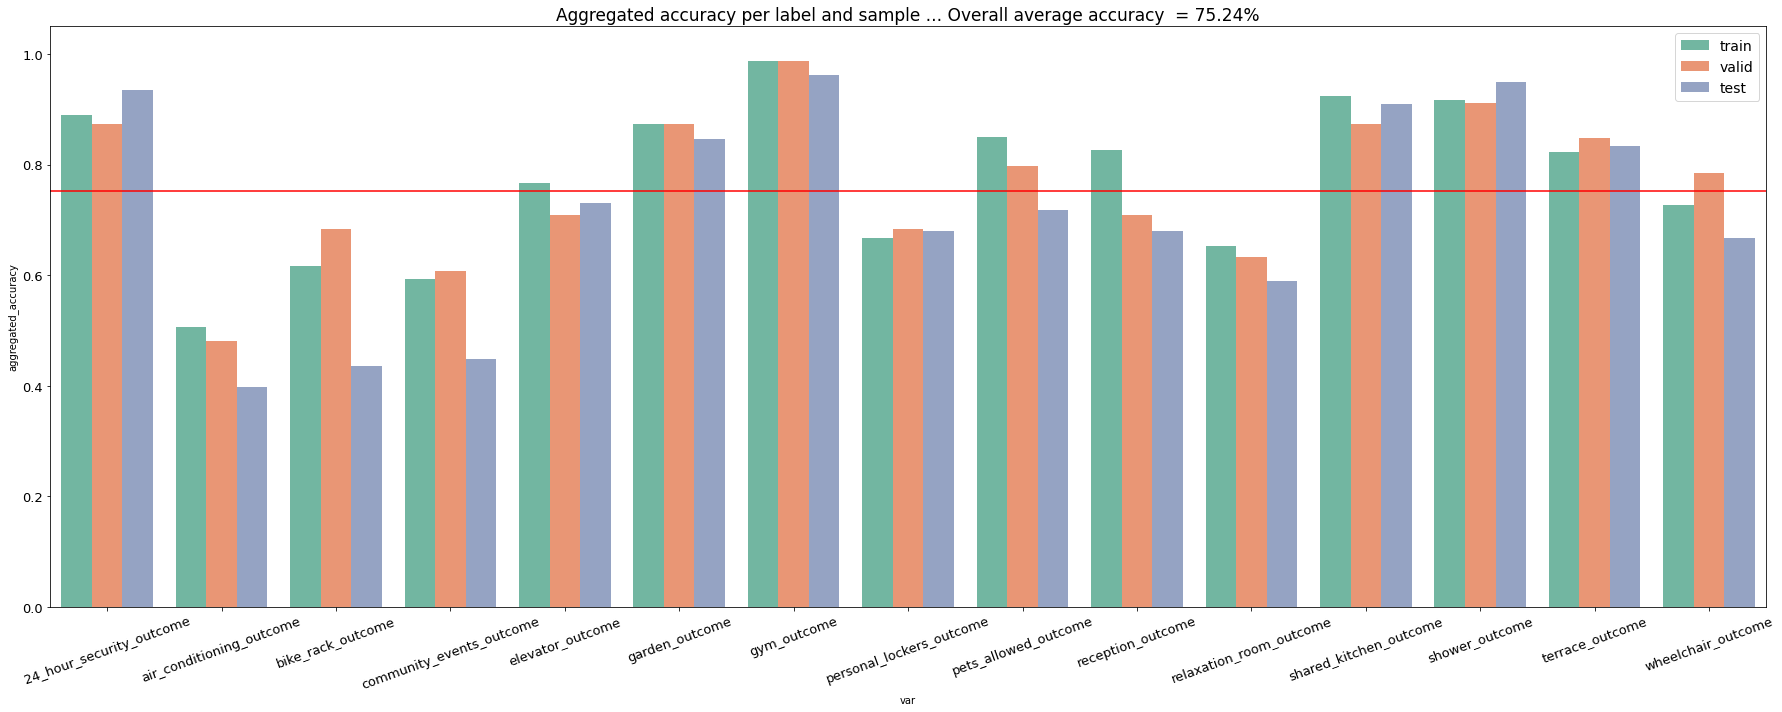

In [82]:
plot_overall_evaluation(df_ev_overall, total = True)

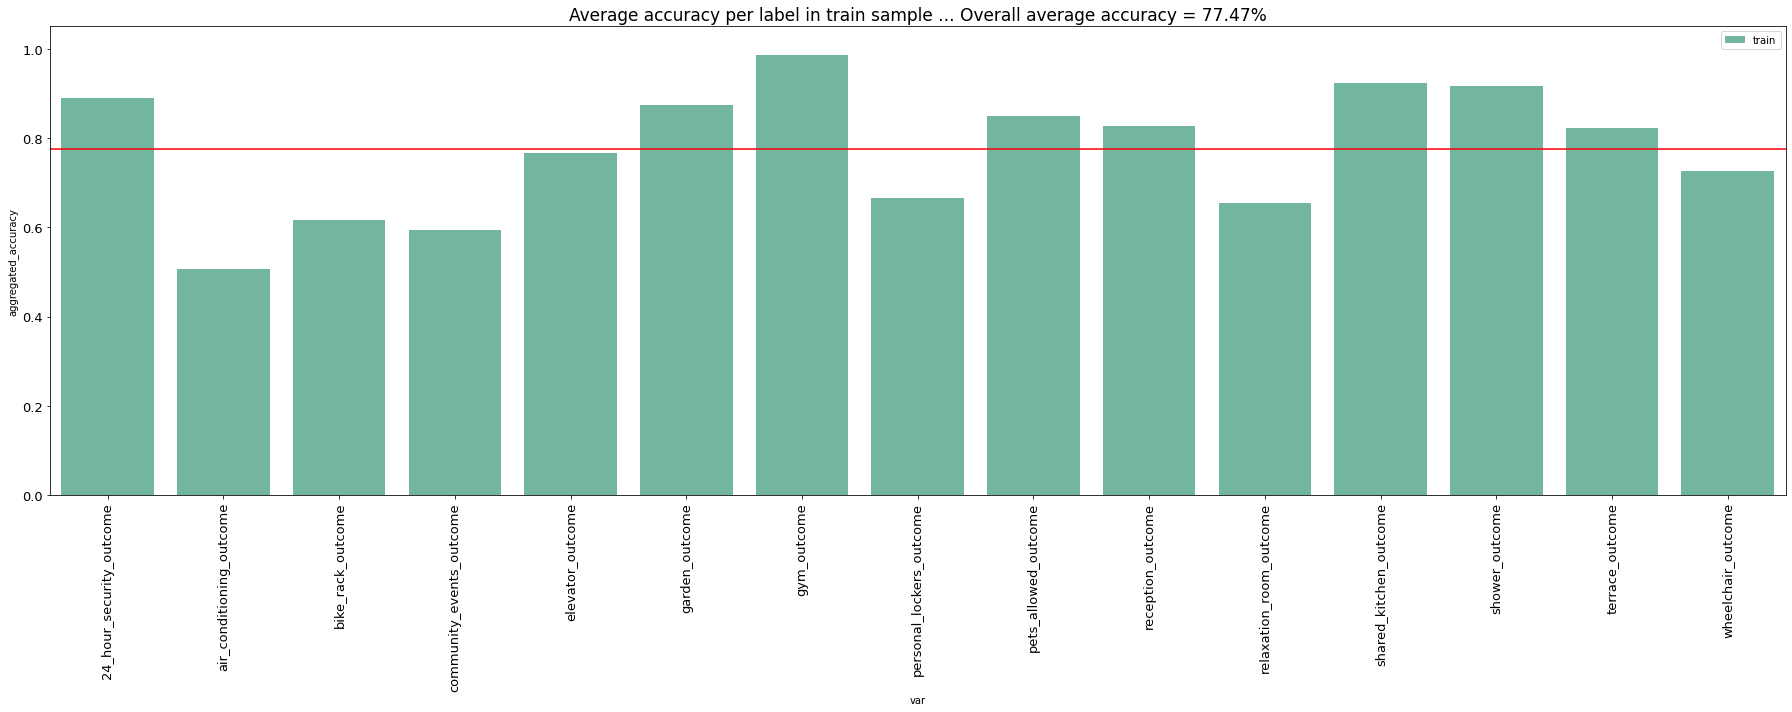

In [83]:
plot_overall_evaluation(train_overall_ev_df, total = False, sample_name = 'train')

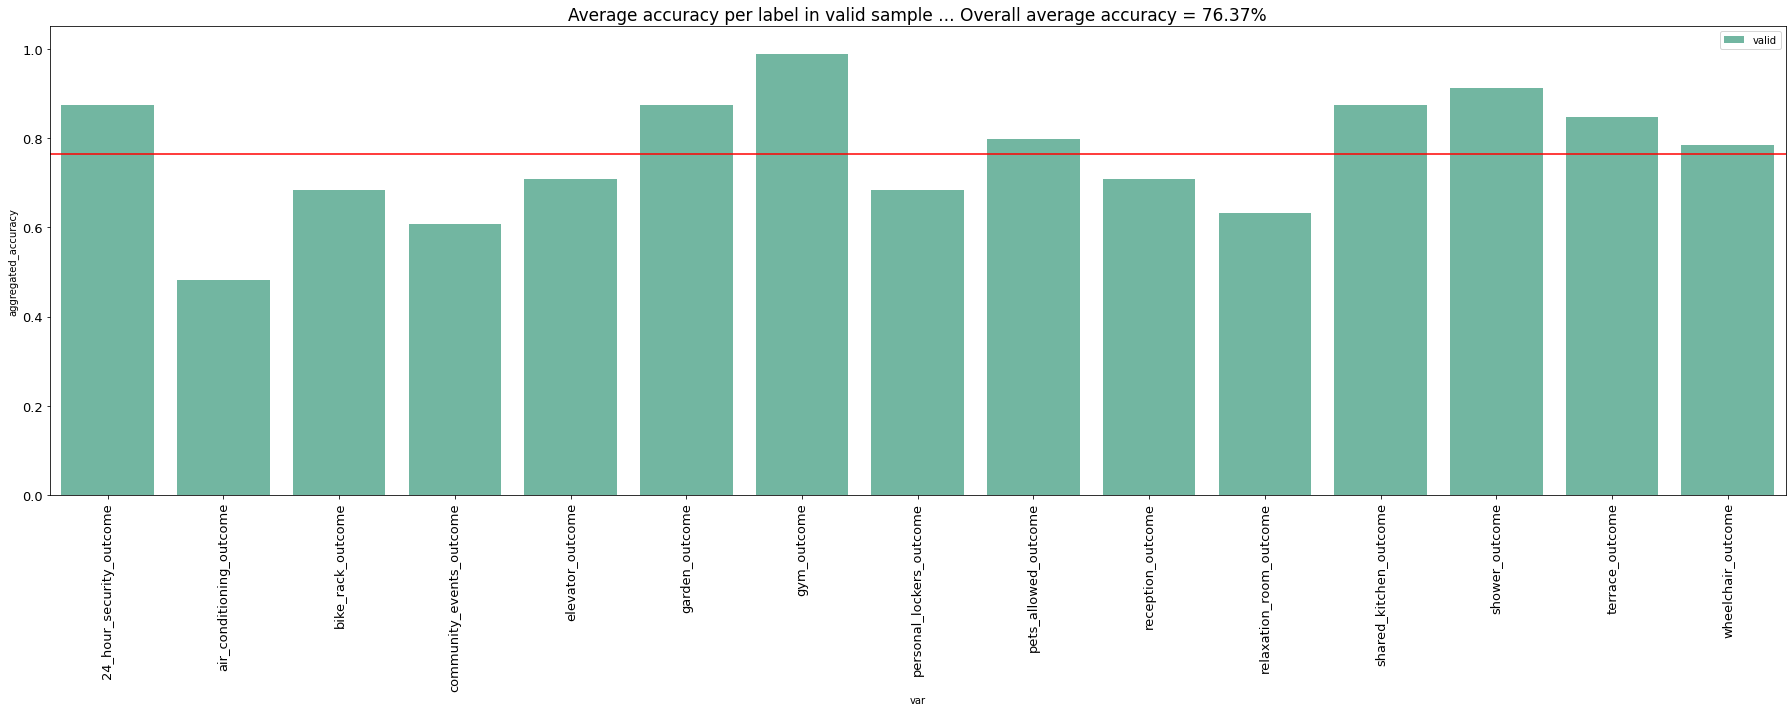

In [84]:
plot_overall_evaluation(valid_overall_ev_df, total = False, sample_name = 'valid')

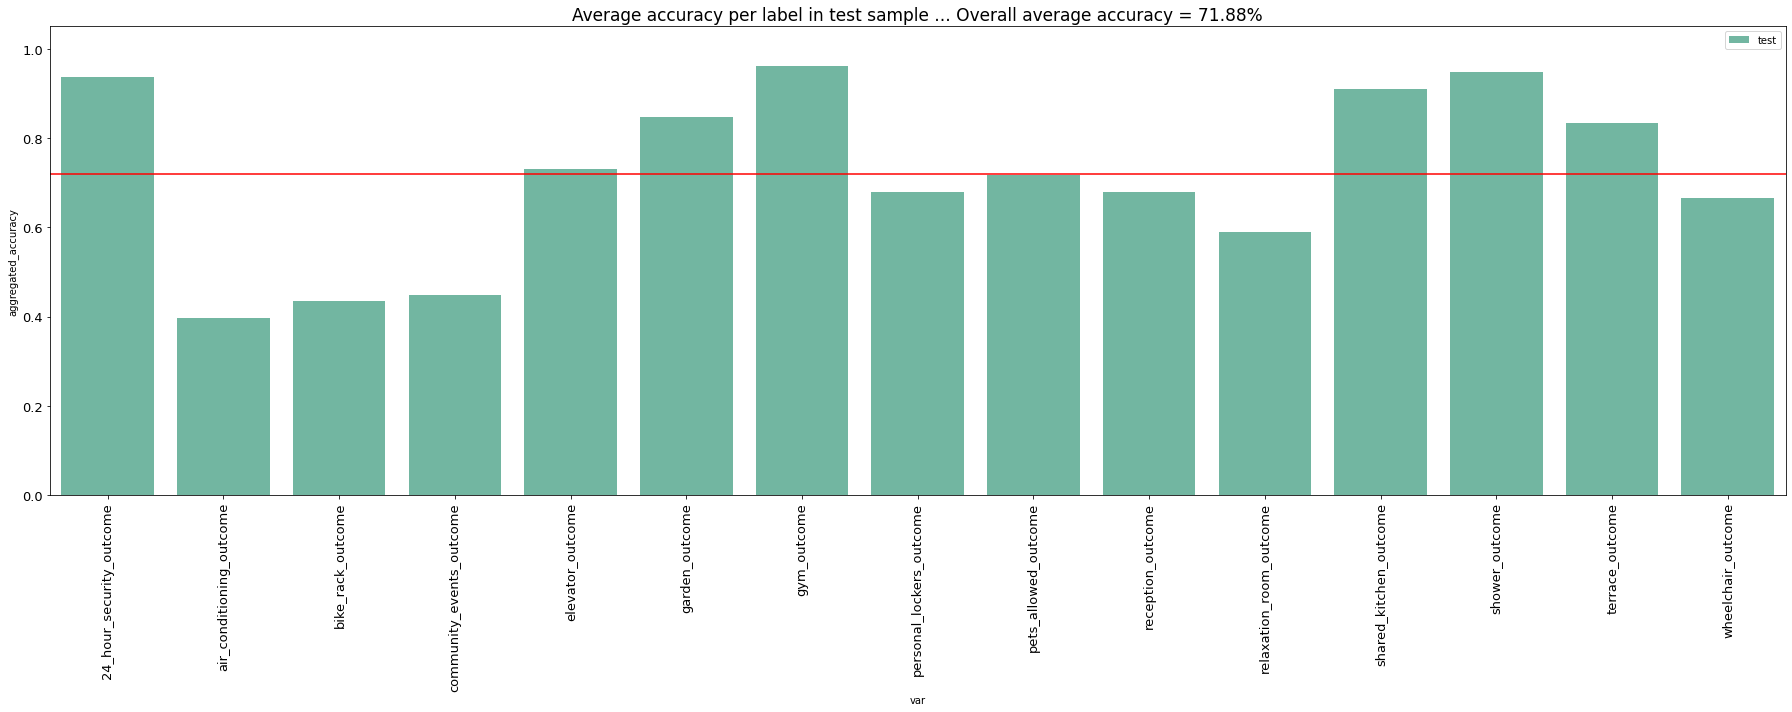

In [85]:
plot_overall_evaluation(test_overall_ev_df, total = False, sample_name = 'test')

Data frame for storing the list of predicted properties/classes per each office.

In [86]:
def preds_prop_listing(predictions, df, num_pics, offices, class_names):
    #data frame for storing predicted classes based on probabilities.

    #data frame for storing true classes.
    true_df = pd.DataFrame(columns = list(df.columns))
    for num, pic in zip(num_pics, offices):
        for i in range(num):
            true_row = df.query(f'location_id == {pic}')
            true_df = pd.concat((true_df, true_row))
    
    #dataframe for storing predicted probabilities per class. 
    pred_df = pd.DataFrame(pd.DataFrame(predictions, columns = [f'{c}_prob' for c in class_names]))

    joined_df = pd.concat((true_df.reset_index()[['location_id']], pred_df), axis=1)

    joined_df = joined_df.groupby('location_id')[[f'{c}_prob' for c in class_names]].mean().reset_index()

    for c in class_names:
      joined_df[c] = joined_df[f'{c}_prob'].apply(lambda x: 1 if x > 0.5 else 0)

    pred_class_df = joined_df[[i for i in joined_df.columns if i.split('_')[-1] != 'prob']]
    
    #containing list of 1's and 0's indicating occurence of given class.
    pred_class_df['class_indicators'] = pred_class_df.drop('location_id', axis = 1).values.tolist()

    #list for storing the occured class names for each row.
    row_names_list = []

    #for each row find the class names which have occured.
    for _, row in pred_class_df.iterrows():
      name_list = [] #list for storing occured class names in given row.

      #for each class indicator and its name, find the occured ones (1) and attached to list storing the occured class names in given row.
      for num, name in zip(row['class_indicators'], class_names):
        if num == 1:
          name_list.append(name)

      #attach the list of occured class names in given row to the list for storing list of class names for each row.
      row_names_list.append(str([','.join(name_list)]))

    #assigning the list to the data frame
    pred_class_df['class_names'] = [i.replace('[','').replace(']','').replace("'",'') for i in row_names_list]

    return pred_class_df[['location_id', 'class_names']]

In [87]:
train_preds_listing = preds_prop_listing(train_all_predictions, df, train_num_pics, train_offices, class_names)

In [88]:
valid_preds_listing = preds_prop_listing(valid_all_predictions, df, valid_num_pics, valid_offices, class_names)

In [89]:

test_preds_listing = preds_prop_listing(test_all_predictions, df, test_num_pics, test_offices, class_names)

In [90]:
display(train_preds_listing)

,location_id,class_names
0,6631,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
1,11986,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen,wheelchair"
2,12217,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen,wheelchair"
3,12218,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen,wheelchair"
4,12219,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen,terrace,wheelchair"
...,...,...
295,83402,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
296,89935,"24_hour_security,air_conditioning,community_events,elevator,reception,relaxation_room,shared_kitchen"
297,103037,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
298,103051,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"


In [91]:
display(valid_preds_listing)

,location_id,class_names
0,2862,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
1,6617,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
2,11971,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
3,12329,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
4,12330,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
...,...,...
74,72941,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
75,73886,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
76,81509,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,personal_lockers,reception,relaxation_room,shared_kitchen,terrace,wheelchair"
77,101537,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen"


In [92]:
display(test_preds_listing)

,location_id,class_names
0,6624,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
1,12220,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
2,15473,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,personal_lockers,pets_allowed,reception,relaxation_room,shared_kitchen,wheelchair"
3,15846,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
4,16060,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen,wheelchair"
...,...,...
73,74019,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
74,74224,"24_hour_security,air_conditioning,community_events,elevator,reception,relaxation_room,shared_kitchen"
75,102908,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
76,105307,"24_hour_security,air_conditioning,community_events,elevator,reception,relaxation_room,shared_kitchen"


In [93]:
def plot_true_preds(preds_listing, df, sample_name = None):
  preds_df = pd.concat((preds_listing[['location_id']], preds_listing['class_names'].str.get_dummies(',')), axis = 1)
  true_df = df[df['location_id'].isin(preds_df['location_id'])].copy().reset_index(drop = True)

  for col in true_df.columns:
    if col not in preds_df.columns:
      preds_df[col] = 0

  preds_df.columns = true_df.columns

  df_list = []

  for d, name in zip([true_df, preds_df], ['true labels', 'predicted labels']):
      d.drop('location_id', axis = 1, inplace = True)

      temp_df = d.sum().reset_index().rename(columns = {'index':'class', 0:'count'})
      temp_df['label_type'] = name

      df_list.append(temp_df)

  final_df = pd.concat((df_list[0], df_list[1]))

  title = 'whole' if sample_name == None else sample_name

  plt.figure(figsize = (20, 10))
  sns.barplot(data = final_df, x ='class', y = 'count', hue = 'label_type', palette = 'Set2')
  plt.xticks(rotation = 90)

  plt.title(f'Distribution of predicted and true classes on the {title} sample', size = 17)
  plt.tight_layout()
  plt.show()

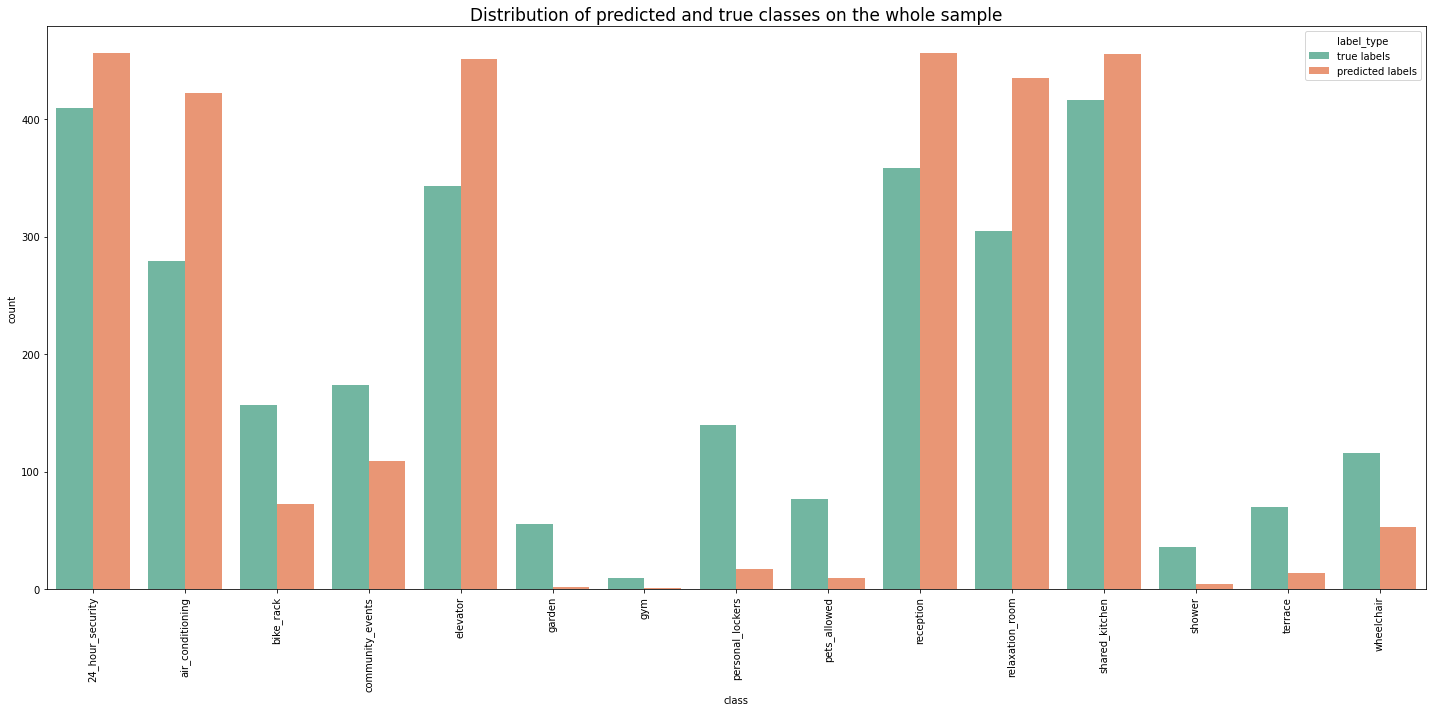

In [94]:
plot_true_preds(pd.concat((train_preds_listing, valid_preds_listing, test_preds_listing)), df)

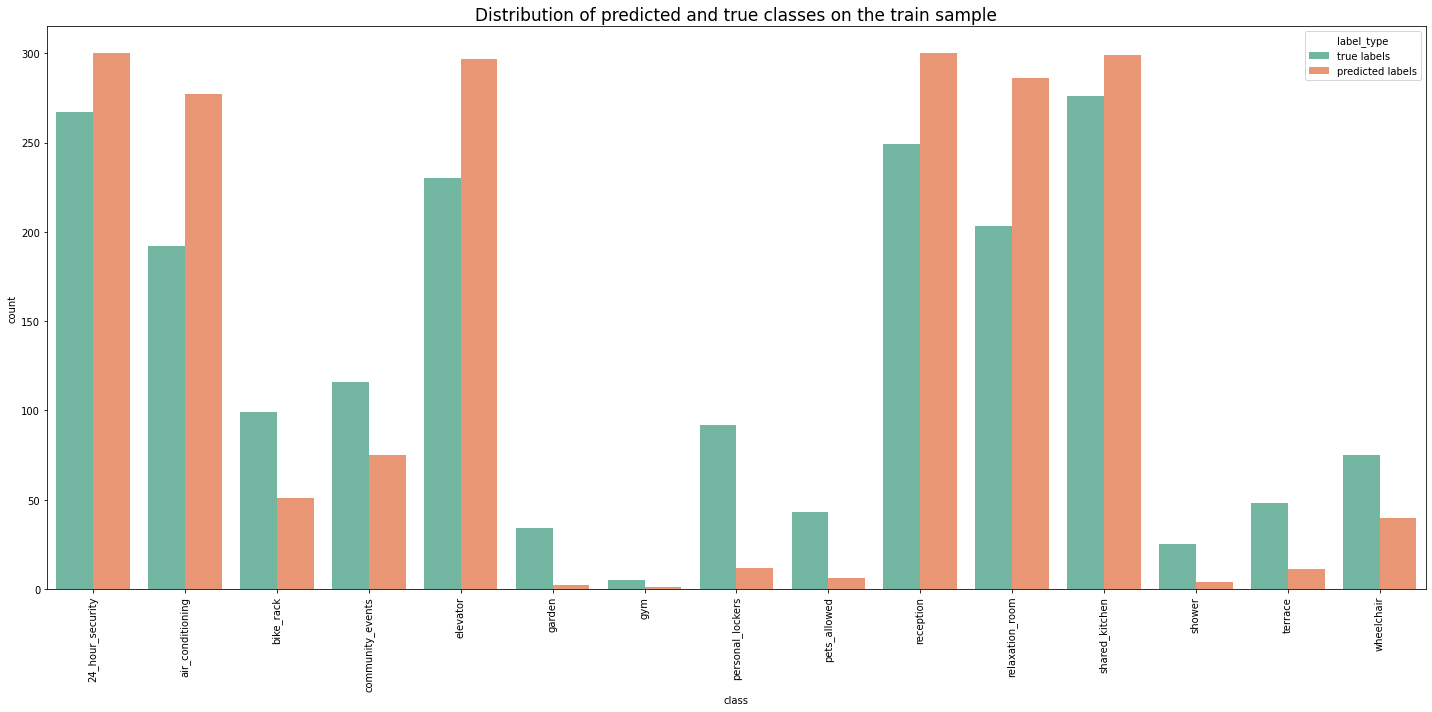

In [95]:
plot_true_preds(train_preds_listing, df, sample_name = 'train')

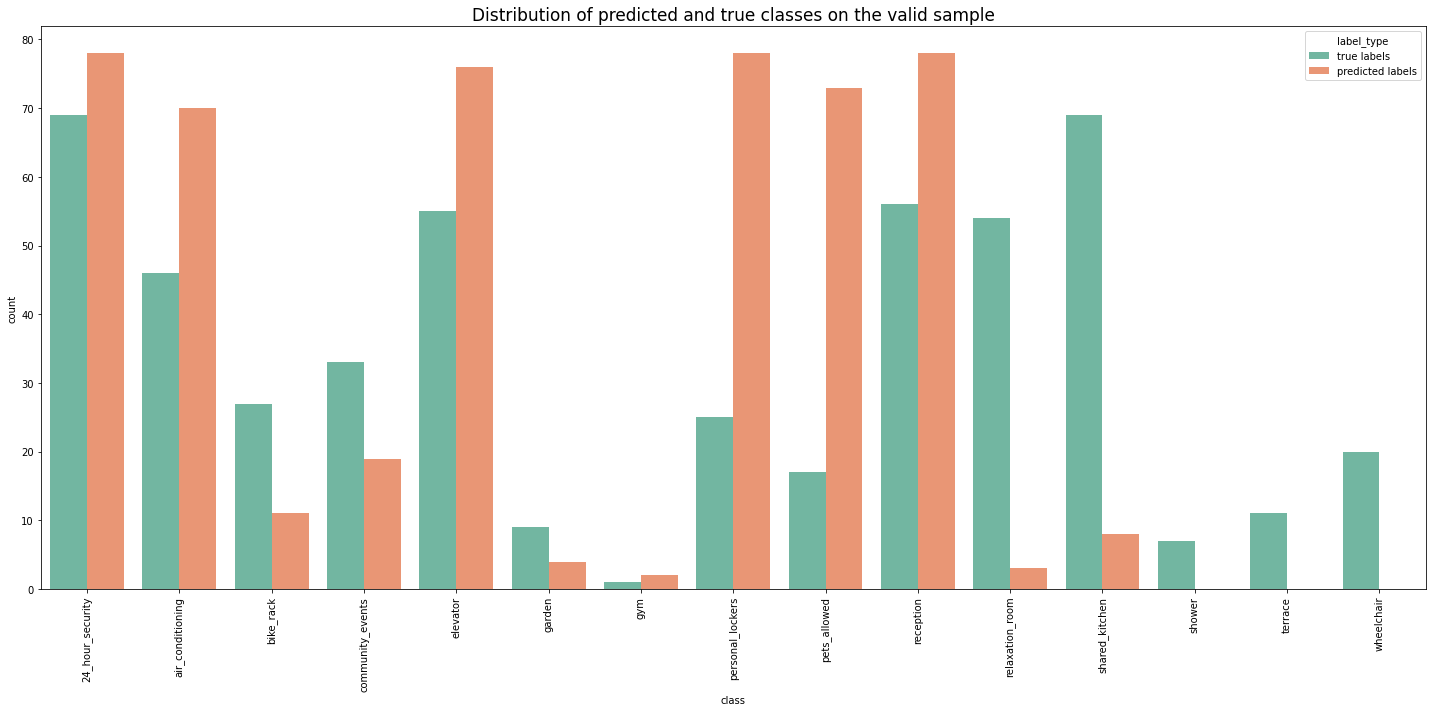

In [96]:
plot_true_preds(valid_preds_listing, df, sample_name = 'valid')

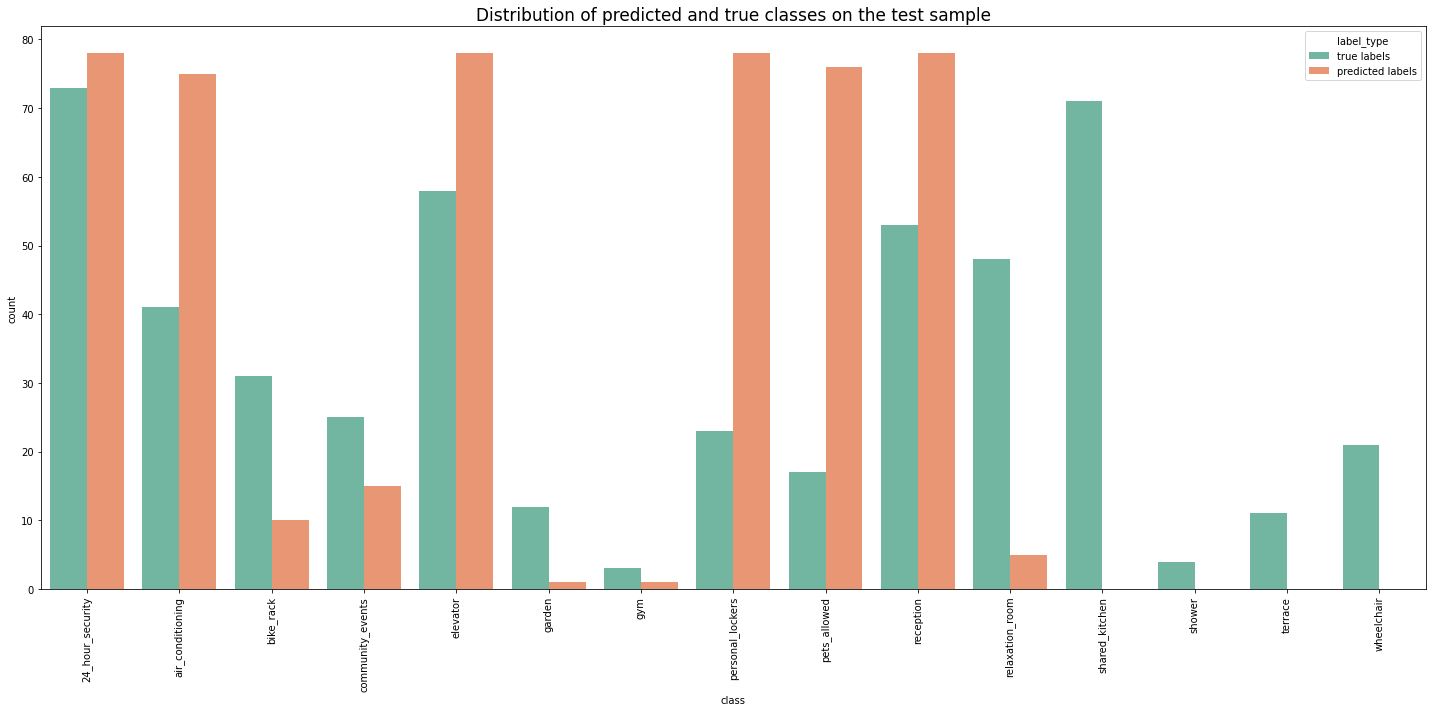

In [76]:
plot_true_preds(test_preds_listing, df, sample_name = 'test')